In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


df = pd.read_csv('All_13100_Entries_with_Nutrient_Ranges.csv')
df.head()

,N,P,K,temperature,humidity,pH,rainfall,label,Plant_Category,EC (mS/cm) Range,Ca (ppm) Range,Mg (ppm) Range,Na (ppm) Range (Max)
0,58,34,42,18.1006,60.5567,7.5063,33.1599,Origanum majorana,Herb_Spice,1.5-2.5 mS/cm,100-150 ppm,30-50 ppm,< 50 ppm
1,56,40,57,23.7085,71.4758,7.6218,27.2026,Coriandrum sativum,Unclassified,1.5-2.5 mS/cm,100-180 ppm,30-50 ppm,< 60 ppm
2,136,37,81,18.2818,68.8113,7.3104,19.4648,Cucurbita pepo,Fruiting_Veg,2.0-4.5 mS/cm,180-250 ppm,40-70 ppm,< 50 ppm (Sensitive)
3,90,28,48,27.7032,66.6544,7.3479,48.6461,Mentha piperita,Herb_Spice,1.5-2.5 mS/cm,100-150 ppm,30-50 ppm,< 50 ppm
4,39,40,53,18.7403,53.3352,7.5331,36.7384,Raphanus sativus,Root_Tuber,1.8-2.8 mS/cm,100-180 ppm,30-60 ppm,< 70 ppm


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   N                     13100 non-null  int64  
 1   P                     13100 non-null  int64  
 2   K                     13100 non-null  int64  
 3   temperature           13100 non-null  float64
 4   humidity              13100 non-null  float64
 5   pH                    13100 non-null  float64
 6   rainfall              13100 non-null  float64
 7   label                 13100 non-null  object 
 8   Plant_Category        13100 non-null  object 
 9   EC (mS/cm) Range      13100 non-null  object 
 10  Ca (ppm) Range        13100 non-null  object 
 11  Mg (ppm) Range        13100 non-null  object 
 12  Na (ppm) Range (Max)  13100 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 1.3+ MB


In [3]:
df.describe()

,N,P,K,temperature,humidity,pH,rainfall
count,13100.000000,13100.000000,13100.000000,13100.000000,13100.000000,13100.000000,13100.000000
mean,72.115802,39.446489,61.686031,21.921862,64.019293,7.145258,60.418725
std,43.418087,19.023604,36.204850,5.933828,10.740221,0.729565,37.181436
min,0.000000,0.000000,0.000000,-1.948600,3.928400,4.299400,0.000000
25%,36.000000,26.000000,36.000000,17.493525,57.983775,6.681100,34.182700
50%,68.000000,41.000000,57.000000,21.615050,64.346450,7.199900,53.237150
75%,104.000000,53.000000,84.000000,26.167850,70.854100,7.657575,79.785750
max,213.000000,110.000000,185.000000,46.495900,100.000000,9.854600,300.882500


In [4]:
type(df['EC (mS/cm) Range'][0])

str

In [5]:
if 'Plant_Category' in df.columns:
    print(df["Plant_Category"].unique())
else:
    print("Error: 'Plant_Category' column not found in the DataFrame.")
    print("Available columns:", df.columns)

['Herb_Spice' 'Unclassified' 'Fruiting_Veg' 'Root_Tuber' 'Cereal_Grass'
 'Legume' 'Tree_Fruit' 'Leafy_Veg']


In [6]:
columns_to_process = {
    'EC (mS/cm) Range': 'mS/cm',
    'Ca (ppm) Range': 'ppm',
    'Mg (ppm) Range': 'ppm',
    'Na (ppm) Range (Max)': 'ppm'
}

def process_range_column(df, col_name, unit_to_remove):

    cleaned_series = df[col_name].str.replace(r"\(.*\)", "", regex=True)
    cleaned_series = cleaned_series.str.replace(unit_to_remove, "", regex=False).str.strip()


    # إنشاء أسماء الأعمدة الجديدة
    base_name = col_name.split('(')[0].strip().replace(' Range', '').replace(' (Max)', '')
    min_col_name = base_name + '_Min'
    max_col_name = base_name + '_Max'

    df[min_col_name] = np.nan
    df[max_col_name] = np.nan

    for index, value in cleaned_series.items():
        if pd.isna(value) or value == '':
            continue

        value = value.strip()

        if '-' in value:
            try:
                min_val, max_val = map(float, value.split('-'))
                df.loc[index, min_col_name] = min_val
                df.loc[index, max_col_name] = max_val
            except ValueError:
                pass

        elif '<' in value:
            try:
                max_val = float(value.replace('<', '').strip())
                df.loc[index, min_col_name] = 0.0
                df.loc[index, max_col_name] = max_val
            except ValueError:
                pass

        else:
            try:
                single_val = float(value)
                df.loc[index, min_col_name] = 0.0
                df.loc[index, max_col_name] = single_val
            except ValueError:
                pass

    return df

In [7]:
for col, unit in columns_to_process.items():
    df = process_range_column(df, col, unit)


In [8]:
df = df.drop(columns=list(columns_to_process.keys()))

In [9]:
df.head(100)

,N,P,K,temperature,humidity,pH,rainfall,label,Plant_Category,EC_Min,EC_Max,Ca_Min,Ca_Max,Mg_Min,Mg_Max,Na_Min,Na_Max
0,58,34,42,18.1006,60.5567,7.5063,33.1599,Origanum majorana,Herb_Spice,1.5,2.5,100.0,150.0,30.0,50.0,0.0,50.0
1,56,40,57,23.7085,71.4758,7.6218,27.2026,Coriandrum sativum,Unclassified,1.5,2.5,100.0,180.0,30.0,50.0,0.0,60.0
2,136,37,81,18.2818,68.8113,7.3104,19.4648,Cucurbita pepo,Fruiting_Veg,2.0,4.5,180.0,250.0,40.0,70.0,0.0,50.0
3,90,28,48,27.7032,66.6544,7.3479,48.6461,Mentha piperita,Herb_Spice,1.5,2.5,100.0,150.0,30.0,50.0,0.0,50.0
4,39,40,53,18.7403,53.3352,7.5331,36.7384,Raphanus sativus,Root_Tuber,1.8,2.8,100.0,180.0,30.0,60.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,22,3,46,25.4400,61.6076,7.5534,47.9932,Ficus carica,Tree_Fruit,1.0,2.5,100.0,200.0,30.0,60.0,0.0,50.0
96,64,31,42,13.6758,60.8599,7.3906,58.5838,Matricaria chamomilla,Unclassified,1.5,2.5,100.0,180.0,30.0,50.0,0.0,60.0
97,34,44,78,30.8434,65.8275,6.6650,68.9403,Vigna unguiculata,Legume,1.0,1.8,80.0,150.0,20.0,40.0,0.0,40.0
98,90,35,35,20.8466,60.2341,6.8216,73.2226,Mentha spicata,Herb_Spice,1.5,2.5,100.0,150.0,30.0,50.0,0.0,50.0


In [10]:
df["Na_Min"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 13100 entries, 0 to 13099
Series name: Na_Min
Non-Null Count  Dtype  
--------------  -----  
12100 non-null  float64
dtypes: float64(1)
memory usage: 102.5 KB


In [11]:
df["Na_Min"].unique()

array([ 0., nan])

In [12]:
df.isna().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
pH,0
rainfall,0
label,0
Plant_Category,0
EC_Min,0


In [13]:
mean_Na = df['Na_Max'].mean()

In [14]:
df['Na_Max'].fillna(mean_Na, inplace=True)

/tmp/ipython-input-3877543950.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Na_Max'].fillna(mean_Na, inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N               13100 non-null  int64  
 1   P               13100 non-null  int64  
 2   K               13100 non-null  int64  
 3   temperature     13100 non-null  float64
 4   humidity        13100 non-null  float64
 5   pH              13100 non-null  float64
 6   rainfall        13100 non-null  float64
 7   label           13100 non-null  object 
 8   Plant_Category  13100 non-null  object 
 9   EC_Min          13100 non-null  float64
 10  EC_Max          13100 non-null  float64
 11  Ca_Min          13100 non-null  float64
 12  Ca_Max          13100 non-null  float64
 13  Mg_Min          13100 non-null  float64
 14  Mg_Max          13100 non-null  float64
 15  Na_Min          12100 non-null  float64
 16  Na_Max          13100 non-null  float64
dtypes: float64(12), int64(3), objec

In [16]:
df['Na_Max'].unique()

array([50.        , 60.        , 70.        , 53.47107438, 40.        ])

In [68]:
df['Na_Max'].nunique()

5

In [69]:
df['Na_Max'].isna().sum()

np.int64(0)

In [18]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall', 'label',
       'Plant_Category', 'EC_Min', 'EC_Max', 'Ca_Min', 'Ca_Max', 'Mg_Min',
       'Mg_Max', 'Na_Min', 'Na_Max'],
      dtype='object')

In [19]:
df.head()

,N,P,K,temperature,humidity,pH,rainfall,label,Plant_Category,EC_Min,EC_Max,Ca_Min,Ca_Max,Mg_Min,Mg_Max,Na_Min,Na_Max
0,58,34,42,18.1006,60.5567,7.5063,33.1599,Origanum majorana,Herb_Spice,1.5,2.5,100.0,150.0,30.0,50.0,0.0,50.0
1,56,40,57,23.7085,71.4758,7.6218,27.2026,Coriandrum sativum,Unclassified,1.5,2.5,100.0,180.0,30.0,50.0,0.0,60.0
2,136,37,81,18.2818,68.8113,7.3104,19.4648,Cucurbita pepo,Fruiting_Veg,2.0,4.5,180.0,250.0,40.0,70.0,0.0,50.0
3,90,28,48,27.7032,66.6544,7.3479,48.6461,Mentha piperita,Herb_Spice,1.5,2.5,100.0,150.0,30.0,50.0,0.0,50.0
4,39,40,53,18.7403,53.3352,7.5331,36.7384,Raphanus sativus,Root_Tuber,1.8,2.8,100.0,180.0,30.0,60.0,0.0,70.0


In [20]:
df.drop('Na_Min', axis=1, inplace=True)

In [21]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall', 'label',
       'Plant_Category', 'EC_Min', 'EC_Max', 'Ca_Min', 'Ca_Max', 'Mg_Min',
       'Mg_Max', 'Na_Max'],
      dtype='object')

In [22]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall',
                  'EC_Min', 'EC_Max', 'Ca_Min', 'Ca_Max', 'Mg_Min', 'Mg_Max', 'Na_Max']

scaler = StandardScaler()

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df[numerical_cols].describe().round(2).T)

               count  mean  std   min   25%   50%   75%   max
N            13100.0  -0.0  1.0 -1.66 -0.83 -0.09  0.73  3.24
P            13100.0  -0.0  1.0 -2.07 -0.71  0.08  0.71  3.71
K            13100.0  -0.0  1.0 -1.70 -0.71 -0.13  0.62  3.41
temperature  13100.0   0.0  1.0 -4.02 -0.75 -0.05  0.72  4.14
humidity     13100.0   0.0  1.0 -5.60 -0.56  0.03  0.64  3.35
pH           13100.0  -0.0  1.0 -3.90 -0.64  0.07  0.70  3.71
rainfall     13100.0   0.0  1.0 -1.63 -0.71 -0.19  0.52  6.47
EC_Min       13100.0   0.0  1.0 -1.15 -1.15  0.36  0.36  1.87
EC_Max       13100.0  -0.0  1.0 -1.10 -0.81 -0.08 -0.08  2.85
Ca_Min       13100.0   0.0  1.0 -1.52 -0.07 -0.07 -0.07  2.85
Ca_Max       13100.0  -0.0  1.0 -1.68 -0.76  0.16  0.16  2.32
Mg_Min       13100.0   0.0  1.0 -2.17 -0.53  0.29  0.29  1.94
Mg_Max       13100.0   0.0  1.0 -1.81 -0.20 -0.20  0.88  1.96
Na_Max       13100.0  -0.0  1.0 -1.69 -0.43 -0.43  0.82  2.07


In [67]:
df.dropna(subset=['Plant_Category'], inplace=True)

# One-Hot Encode the 'Plant_Category' column
df = pd.get_dummies(df, columns=['Plant_Category'], prefix='Plant_Category', drop_first=True)

# Display the first few rows of the DataFrame with the new dummy columns
display(df.head())

KeyError: "None of [Index(['Plant_Category'], dtype='object')] are in the [columns]"

In [29]:
df["label"].unique().sum()

'Origanum majorana Coriandrum sativum Cucurbita pepo Mentha piperita Raphanus sativus Hordeum vulgare Beta vulgaris Daucus carota Ziziphus spina-christi Cucurbita moschata Linum usitatissimum Lens culinaris Fragaria × ananassa Oryza sativa Cicer arietinum Vitis vinifera Ammi majus Ficus carica Sorghum bicolor Hibiscus sabdariffa Rosa gallica Citrus reticulata Foeniculum vulgare Ipomoea batatas Brassica oleracea var. italica Pimpinella anisum Citrus limon Beta vulgaris var. conditiva Pisum sativum Curcuma longa Vicia faba Citrus aurantium Carica papaya Cucumis melo Citrullus lanatus Diospyros kaki Apium graveolens Zingiber officinale Zea mays Musa acuminata Cucumis sativus Melissa officinalis Carum carvi Rosmarinus officinalis Allium sativum Prunus domestica Cucumis melo var. cantalupensis Pennisetum glaucum Nigella sativa Lupinus albus Matricaria chamomilla Vigna unguiculata Mentha spicata Gossypium barbadense Citrus paradisi Salvia officinalis Lactuca sativa Helianthus annuus Ocimum b

In [30]:
df["label"].nunique()

112

/tmp/ipython-input-2071788328.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=melted_df[col], x=melted_df['Plant_Category_Encoded'], ax=axes[i], palette="viridis")
/tmp/ipython-input-2071788328.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([label.get_text().replace('Plant_Category_', '') for label in axes[i].get_xticklabels()])
/tmp/ipython-input-2071788328.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=melted_df[col], x=melted_df['Plant_Category_Encoded'], ax=axes[i], palette="viridis")
/tmp/ipython-input-2071788328.py:21: UserWarning: set_ticklabels() should o

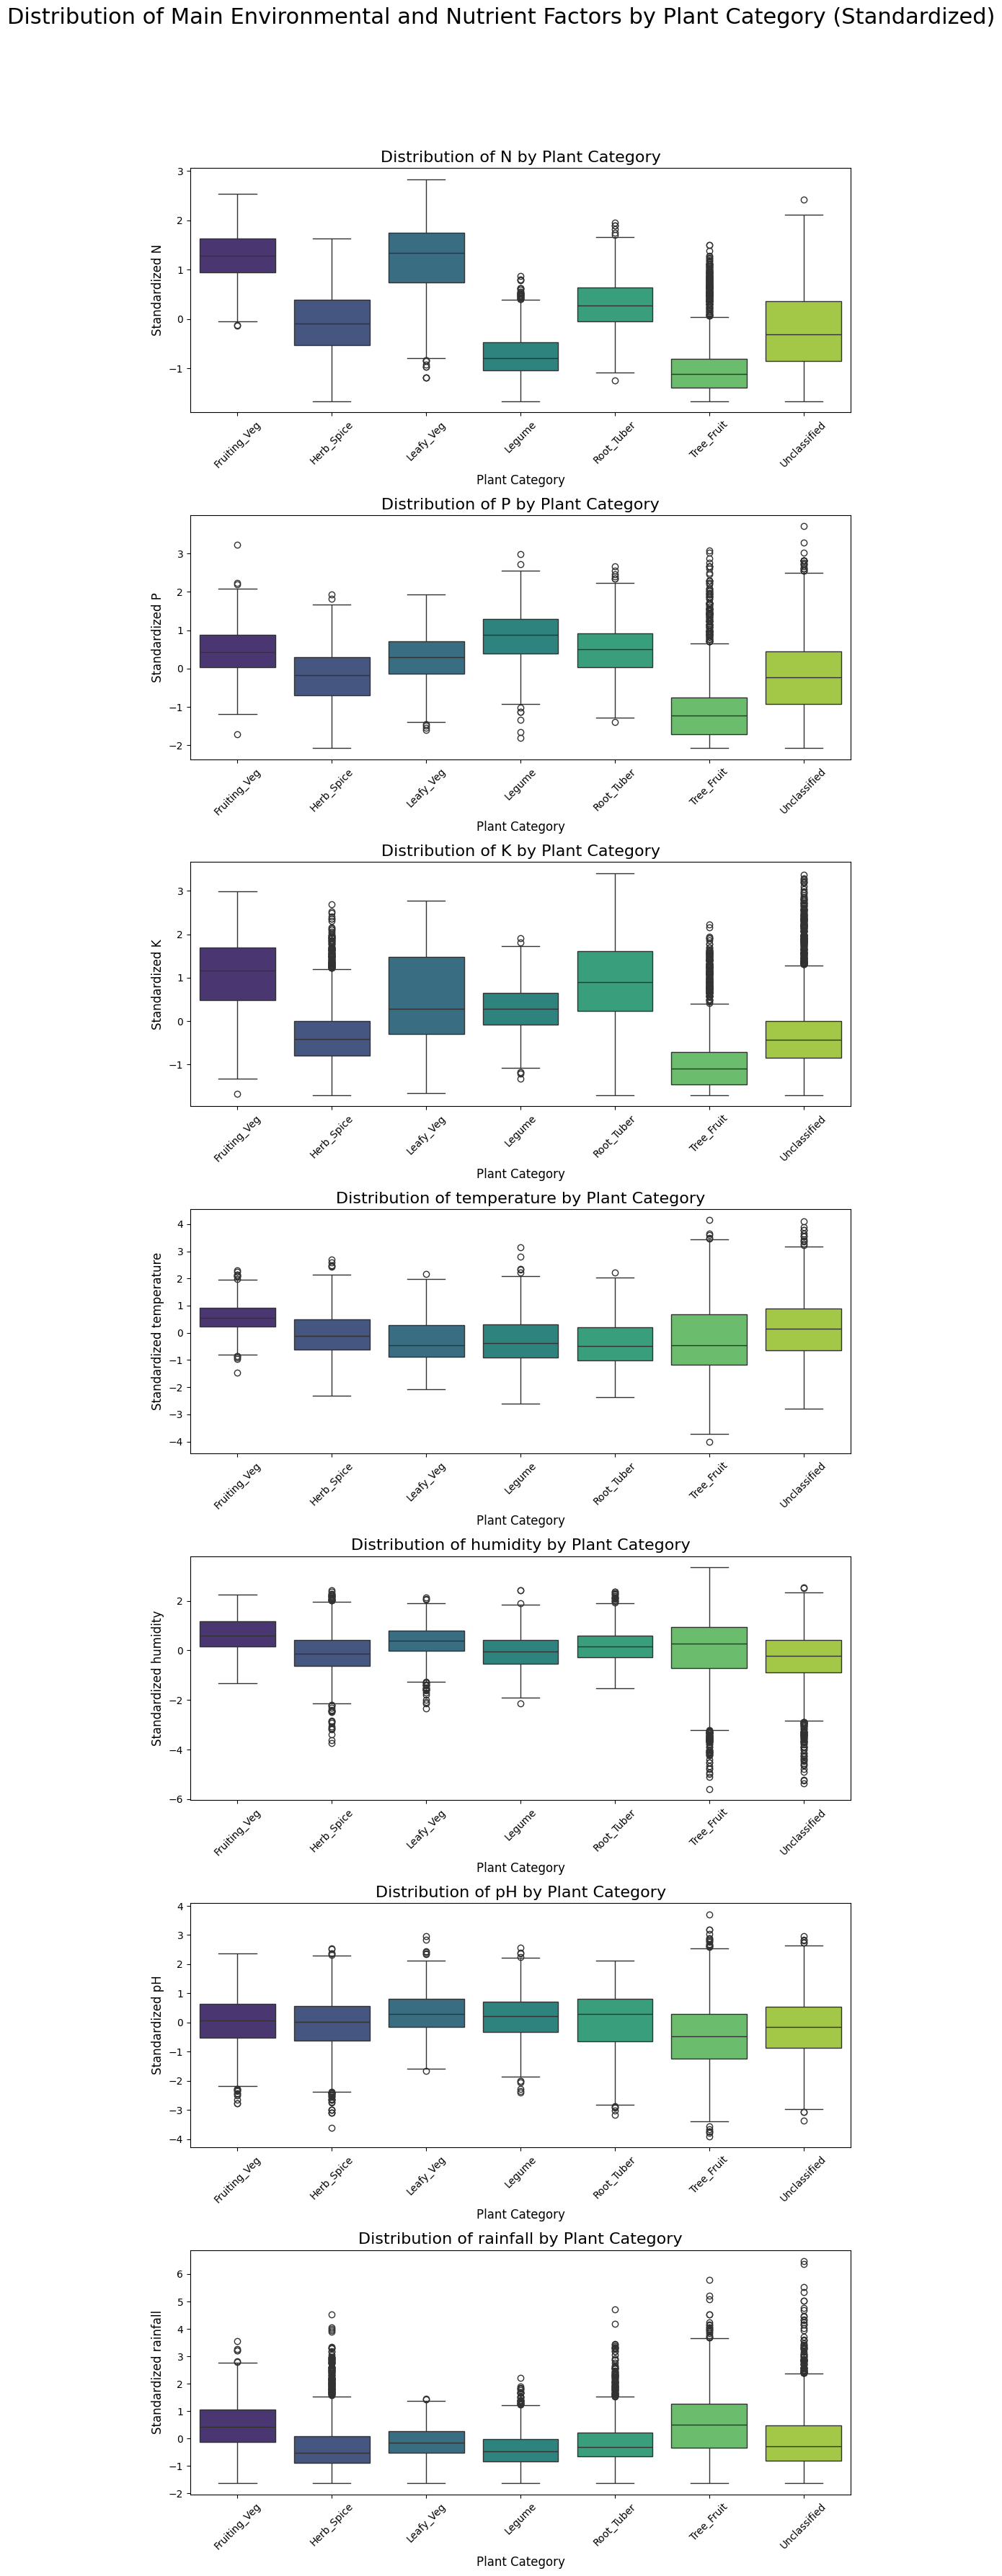

In [65]:
main_numerical_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall']

plant_category_cols = [col for col in df.columns if col.startswith('Plant_Category_')]

fig, axes = plt.subplots(nrows=len(main_numerical_cols), ncols=1, figsize=(10, 5 * len(main_numerical_cols)))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
axes = axes.flatten()


for i, col in enumerate(main_numerical_cols):
    # Melt the DataFrame to long format for easier plotting with Seaborn
    melted_df = df.melt(id_vars=[col], value_vars=plant_category_cols, var_name='Plant_Category_Encoded', value_name='Value')
    melted_df = melted_df[melted_df['Value'] == True] # Filter for the actual categories

    sns.boxplot(y=melted_df[col], x=melted_df['Plant_Category_Encoded'], ax=axes[i], palette="viridis")

    axes[i].set_title(f'Distribution of {col} by Plant Category', fontsize=16)
    axes[i].set_xlabel('Plant Category', fontsize=12)
    axes[i].set_ylabel(f'Standardized {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10) # تدوير أسماء الفئات لتجنب التداخل
    axes[i].set_xticklabels([label.get_text().replace('Plant_Category_', '') for label in axes[i].get_xticklabels()])


plt.suptitle('Distribution of Main Environmental and Nutrient Factors by Plant Category (Standardized)', fontsize=22, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig('Plant_Category_Factors_Boxplots.png')
plt.show()

In [34]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall', 'label',
       'EC_Min', 'EC_Max', 'Ca_Min', 'Ca_Max', 'Mg_Min', 'Mg_Max', 'Na_Max',
       'Plant_Category_Fruiting_Veg', 'Plant_Category_Herb_Spice',
       'Plant_Category_Leafy_Veg', 'Plant_Category_Legume',
       'Plant_Category_Root_Tuber', 'Plant_Category_Tree_Fruit',
       'Plant_Category_Unclassified'],
      dtype='object')

In [35]:
df.head()

,N,P,K,temperature,humidity,pH,rainfall,label,EC_Min,EC_Max,...,Mg_Min,Mg_Max,Na_Max,Plant_Category_Fruiting_Veg,Plant_Category_Herb_Spice,Plant_Category_Leafy_Veg,Plant_Category_Legume,Plant_Category_Root_Tuber,Plant_Category_Tree_Fruit,Plant_Category_Unclassified
0,-0.325126,-0.286313,-0.543761,-0.644004,-0.322407,0.494891,-0.733158,Origanum majorana,0.360653,-0.076995,...,0.294719,-0.197169,-0.434971,False,True,False,False,False,False,False
1,-0.371191,0.029097,-0.129436,0.301105,0.694287,0.653210,-0.893386,Coriandrum sativum,0.360653,-0.076995,...,0.294719,-0.197169,0.818160,False,False,False,False,False,False,True
2,1.471429,-0.128608,0.533484,-0.613466,0.446191,0.226365,-1.101504,Cucurbita pepo,1.874935,2.846566,...,1.937618,1.955258,-0.434971,True,False,False,False,False,False,False
3,0.411922,-0.601722,-0.378031,0.974339,0.245359,0.277767,-0.316639,Mentha piperita,0.360653,-0.076995,...,0.294719,-0.197169,-0.434971,False,True,False,False,False,False,False
4,-0.762748,0.029097,-0.239923,-0.536194,-0.994812,0.531627,-0.636910,Raphanus sativus,1.269223,0.361540,...,0.294719,0.879045,2.071292,False,False,False,False,True,False,False


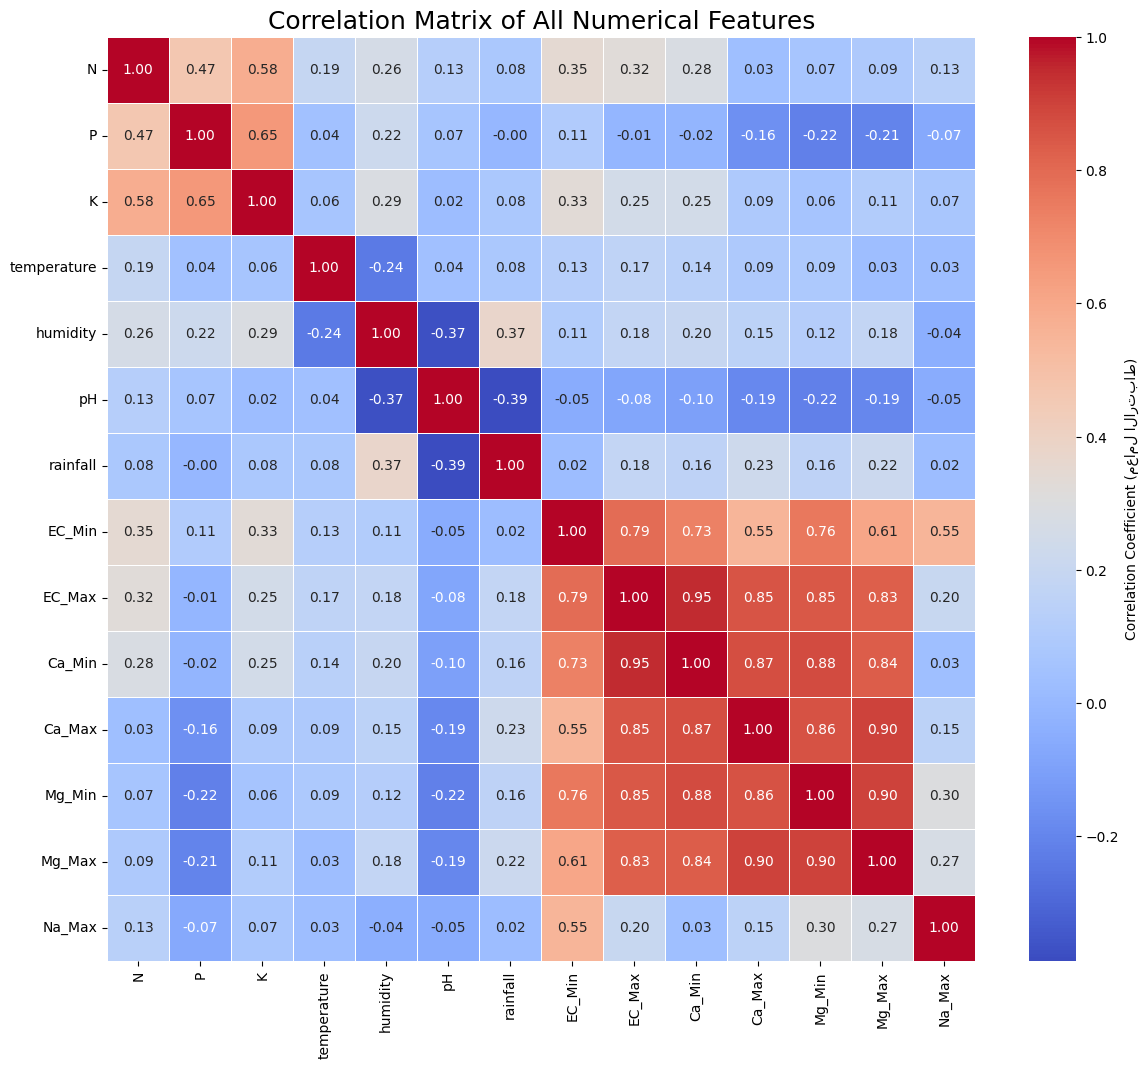

In [64]:
all_numerical_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall',
                      'EC_Min', 'EC_Max', 'Ca_Min', 'Ca_Max', 'Mg_Min', 'Mg_Max', 'Na_Max']

correlation_matrix = df[all_numerical_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            cbar_kws={'label': 'Correlation Coefficient (معامل الارتباط)'})

plt.title('Correlation Matrix of All Numerical Features', fontsize=18)
plt.show()

/tmp/ipython-input-500674186.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Plant_Category', x='Count', data=plant_category_counts_df, palette='Spectral')


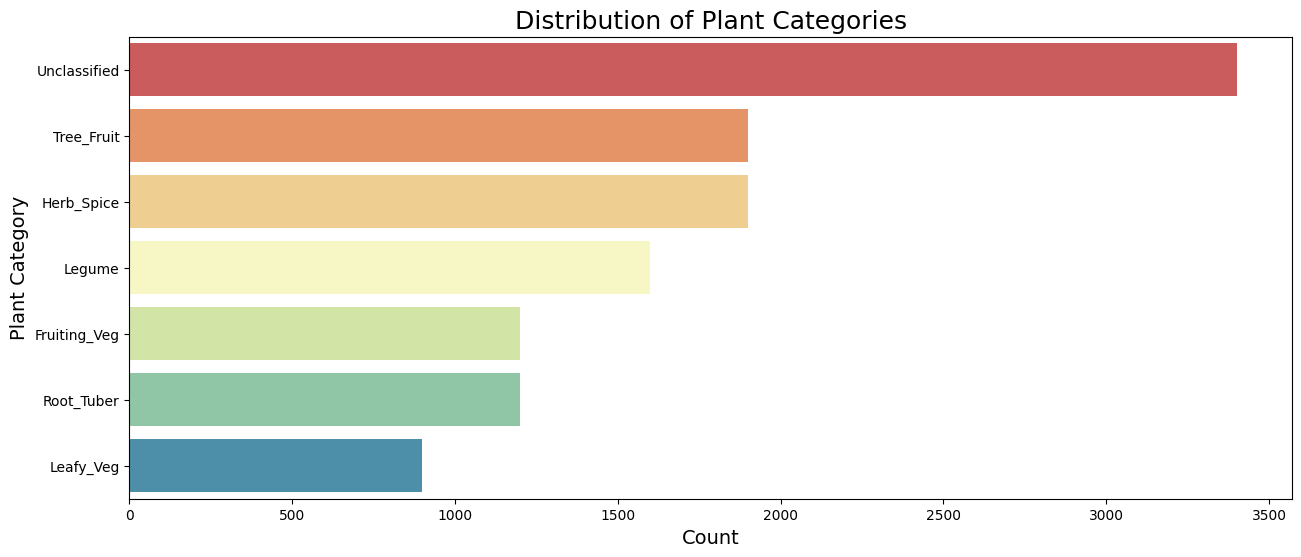

In [39]:
plt.figure(figsize=(15, 6))

# Identify the one-hot encoded Plant_Category columns
plant_category_cols = [col for col in df.columns if col.startswith('Plant_Category_')]

# Calculate the counts for each plant category from the one-hot encoded columns
plant_category_counts = df[plant_category_cols].sum().sort_values(ascending=False)

plant_category_counts_df = plant_category_counts.reset_index()
plant_category_counts_df.columns = ['Plant_Category_Encoded', 'Count']
plant_category_counts_df['Plant_Category'] = plant_category_counts_df['Plant_Category_Encoded'].str.replace('Plant_Category_', '')


sns.barplot(y='Plant_Category', x='Count', data=plant_category_counts_df, palette='Spectral')

plt.title('Distribution of Plant Categories', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Plant Category', fontsize=14)
plt.show()

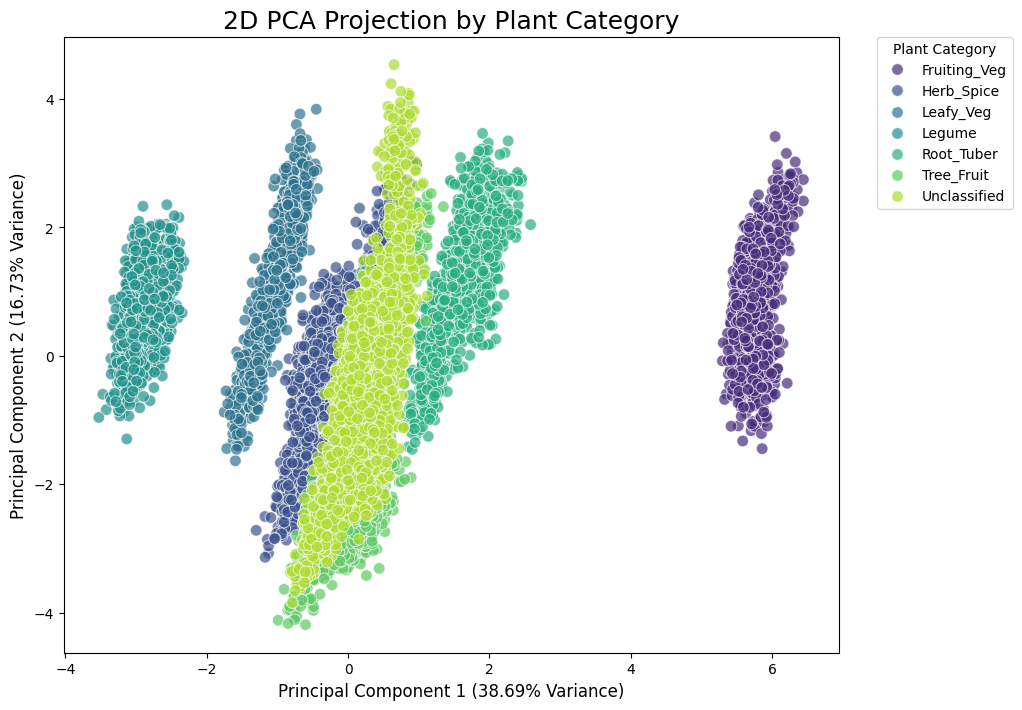

In [41]:
from sklearn.decomposition import PCA

features = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall',
            'EC_Min', 'EC_Max', 'Ca_Min', 'Ca_Max', 'Mg_Min', 'Mg_Max', 'Na_Max']
X = df[features]
# We will use the one-hot encoded columns for the PCA plot.
plant_category_cols = [col for col in df.columns if col.startswith('Plant_Category_')]


pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Concatenate the one-hot encoded plant category columns to the PCA DataFrame
pca_df = pd.concat([pca_df, df[plant_category_cols]], axis = 1)


# We need a single column that indicates the plant category for each row
pca_df_melted = pca_df.melt(id_vars=['PC1', 'PC2'],
                            value_vars=plant_category_cols,
                            var_name='Plant_Category_Encoded',
                            value_name='Value')

# Filter out the rows where the value is False (meaning the plant does not belong to that category)
pca_df_melted = pca_df_melted[pca_df_melted['Value'] == True]

# Extract the actual plant category name from the encoded column name
pca_df_melted['Plant_Category'] = pca_df_melted['Plant_Category_Encoded'].str.replace('Plant_Category_', '')


plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Plant_Category', data=pca_df_melted,
                palette='viridis', s=70, alpha=0.7)
plt.title('2D PCA Projection by Plant Category', fontsize=18)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=12)
plt.legend(title='Plant Category', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

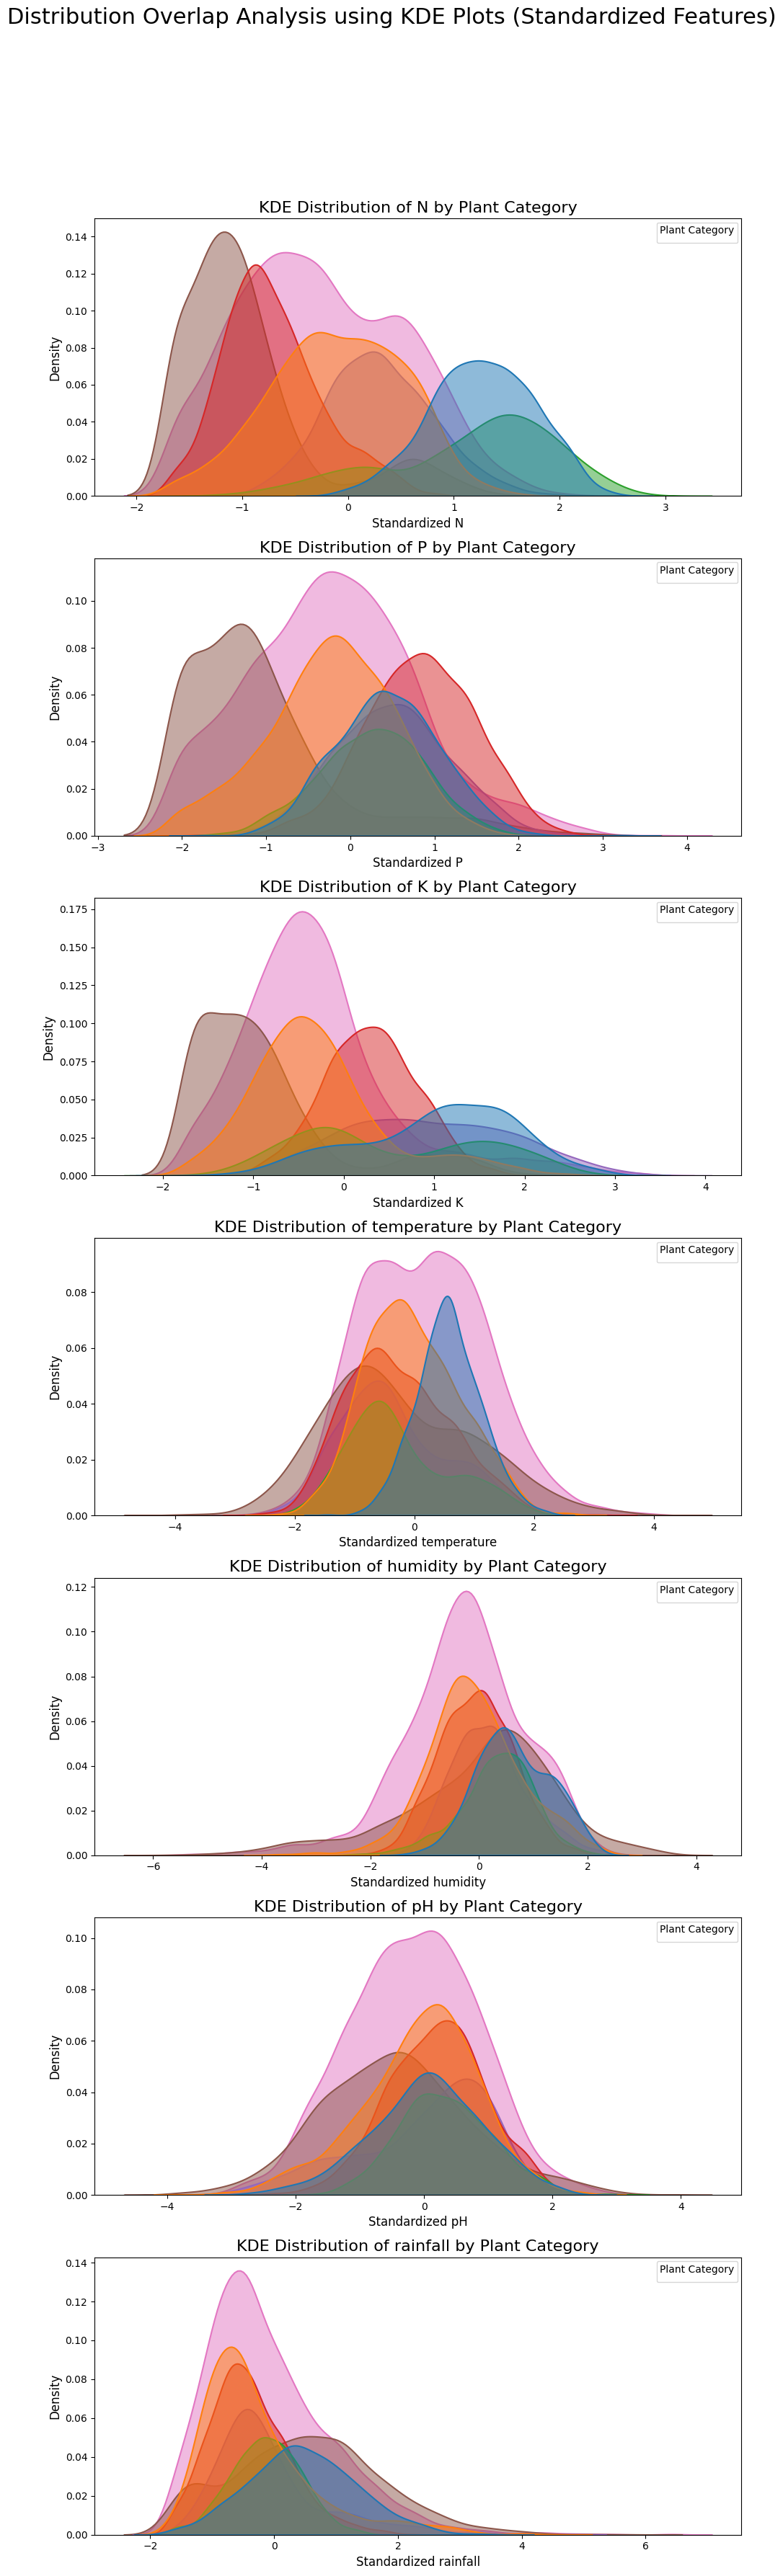

In [43]:
main_numerical_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall']

plant_category_cols = [col for col in df.columns if col.startswith('Plant_Category_')]

fig, axes = plt.subplots(nrows=len(main_numerical_cols), ncols=1, figsize=(10, 5 * len(main_numerical_cols)))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
axes = axes.flatten()

for i, col in enumerate(main_numerical_cols):
    # Melt the DataFrame to long format for easier plotting with Seaborn
    melted_df = df.melt(id_vars=[col], value_vars=plant_category_cols, var_name='Plant_Category_Encoded', value_name='Value')
    melted_df = melted_df[melted_df['Value'] == True] # Filter for the actual categories

    sns.kdeplot(data=melted_df, x=col, hue='Plant_Category_Encoded', ax=axes[i], fill=True, alpha=0.5, linewidth=1.5)

    axes[i].set_title(f'KDE Distribution of {col} by Plant Category', fontsize=16)
    axes[i].set_xlabel(f'Standardized {col}', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)

    # Update legend labels to show actual plant category names
    handles, labels = axes[i].get_legend_handles_labels()
    new_labels = [label.replace('Plant_Category_', '') for label in labels]
    axes[i].legend(handles, new_labels, title='Plant Category', loc='upper right', fontsize=8)


plt.suptitle('Distribution Overlap Analysis using KDE Plots (Standardized Features)', fontsize=22, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [63]:


# Drop rows with missing values in 'Plant_Category' if necessary
df.dropna(subset=['Plant_Category'], inplace=True)

# 선택 أهم ميزات التربة (بالإضافة إلى فئة النبات الأصلية)
soil_features_original = ['N', 'P', 'K', 'Plant_Category']

# إنشاء مخطط الزوج (Pair Plot)
# نستخدم البيانات الأصلية هنا لأن `pairplot` يتطلب عمود فئة واحد للتلوين
sns.pairplot(df[soil_features_original], hue='Plant_Category', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of N, P, and K by Plant Category', y=1.02, fontsize=18)
plt.show()

KeyError: ['Plant_Category']

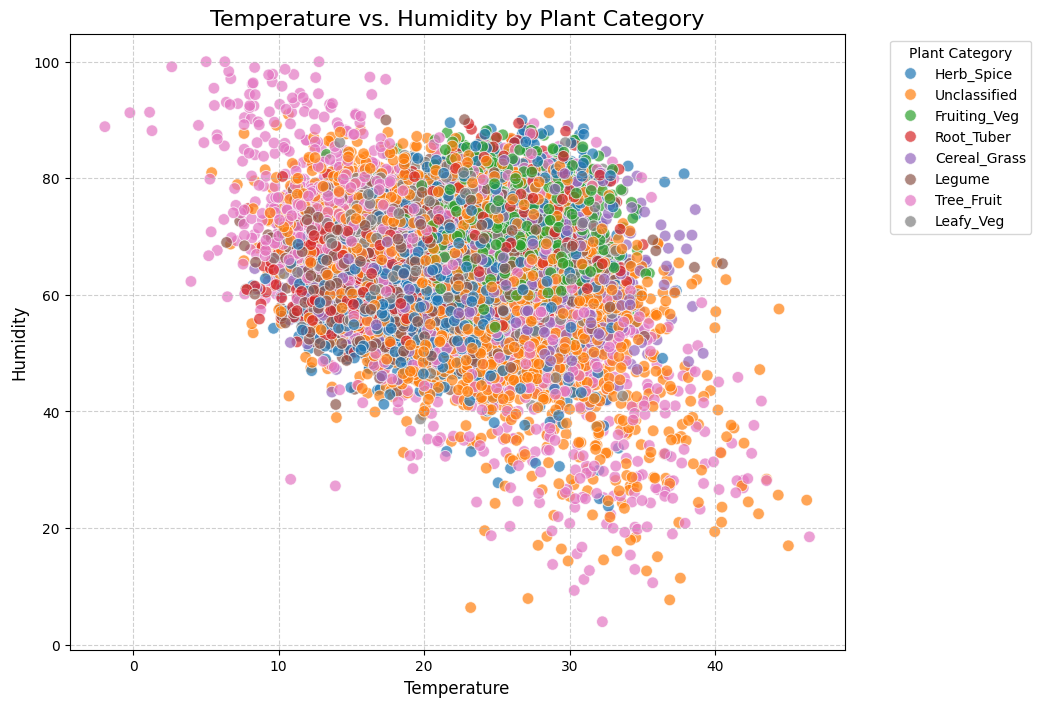

In [50]:
df_original = pd.read_csv('All_13100_Entries_with_Nutrient_Ranges.csv')

df_original.dropna(subset=['Plant_Category'], inplace=True)


plt.figure(figsize=(10, 8))
sns.scatterplot(x='temperature', y='humidity', hue='Plant_Category', data=df_original,
                palette='tab10', s=70, alpha=0.7)

plt.title('Temperature vs. Humidity by Plant Category', fontsize=16)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
plt.legend(title='Plant Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/tmp/ipython-input-4198313607.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='RdYlGn')


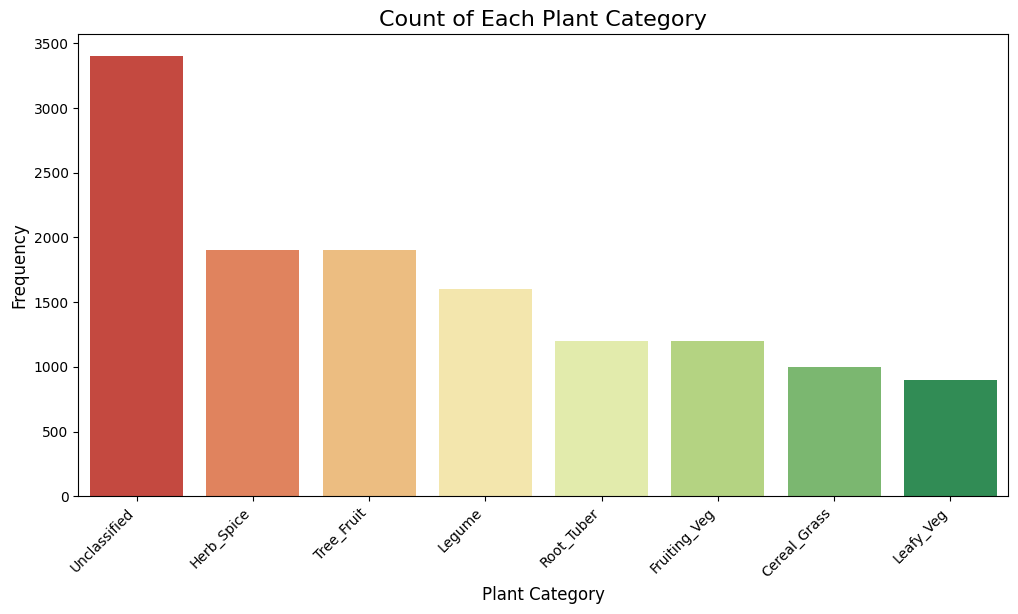

In [62]:
plt.figure(figsize=(12, 6))
category_counts = df_original['Plant_Category'].value_counts()

sns.barplot(x=category_counts.index, y=category_counts.values, palette='RdYlGn')
plt.title('Count of Each Plant Category', fontsize=16)
plt.xlabel('Plant Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

/tmp/ipython-input-1905816733.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='F_Score', data=anova_results, palette='magma')


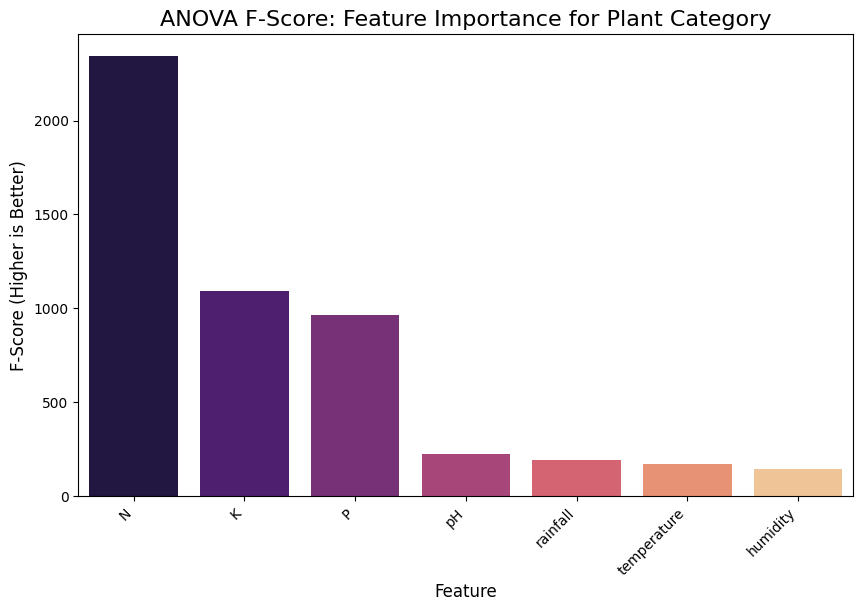

In [61]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_original['label_encoded'] = le.fit_transform(df_original['Plant_Category'])

numerical_cols_for_anova = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall']
X = df_original[numerical_cols_for_anova]
y = df_original['label_encoded']

f_scores, p_values = f_classif(X, y)

anova_results = pd.DataFrame({
    'Feature': numerical_cols_for_anova,
    'F_Score': f_scores,
    'P_Value': p_values
}).sort_values(by='F_Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='F_Score', data=anova_results, palette='magma')
plt.title('ANOVA F-Score: Feature Importance for Plant Category', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('F-Score (Higher is Better)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()